In [1]:
import os
import sys
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

if os.path.abspath(os.path.join(os.getcwd(), "../../")) not in sys.path:
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))
    
from plan_generator.src.config import Configuration
from plan_generator.src.enums import Labels, Colors, LabelsNew

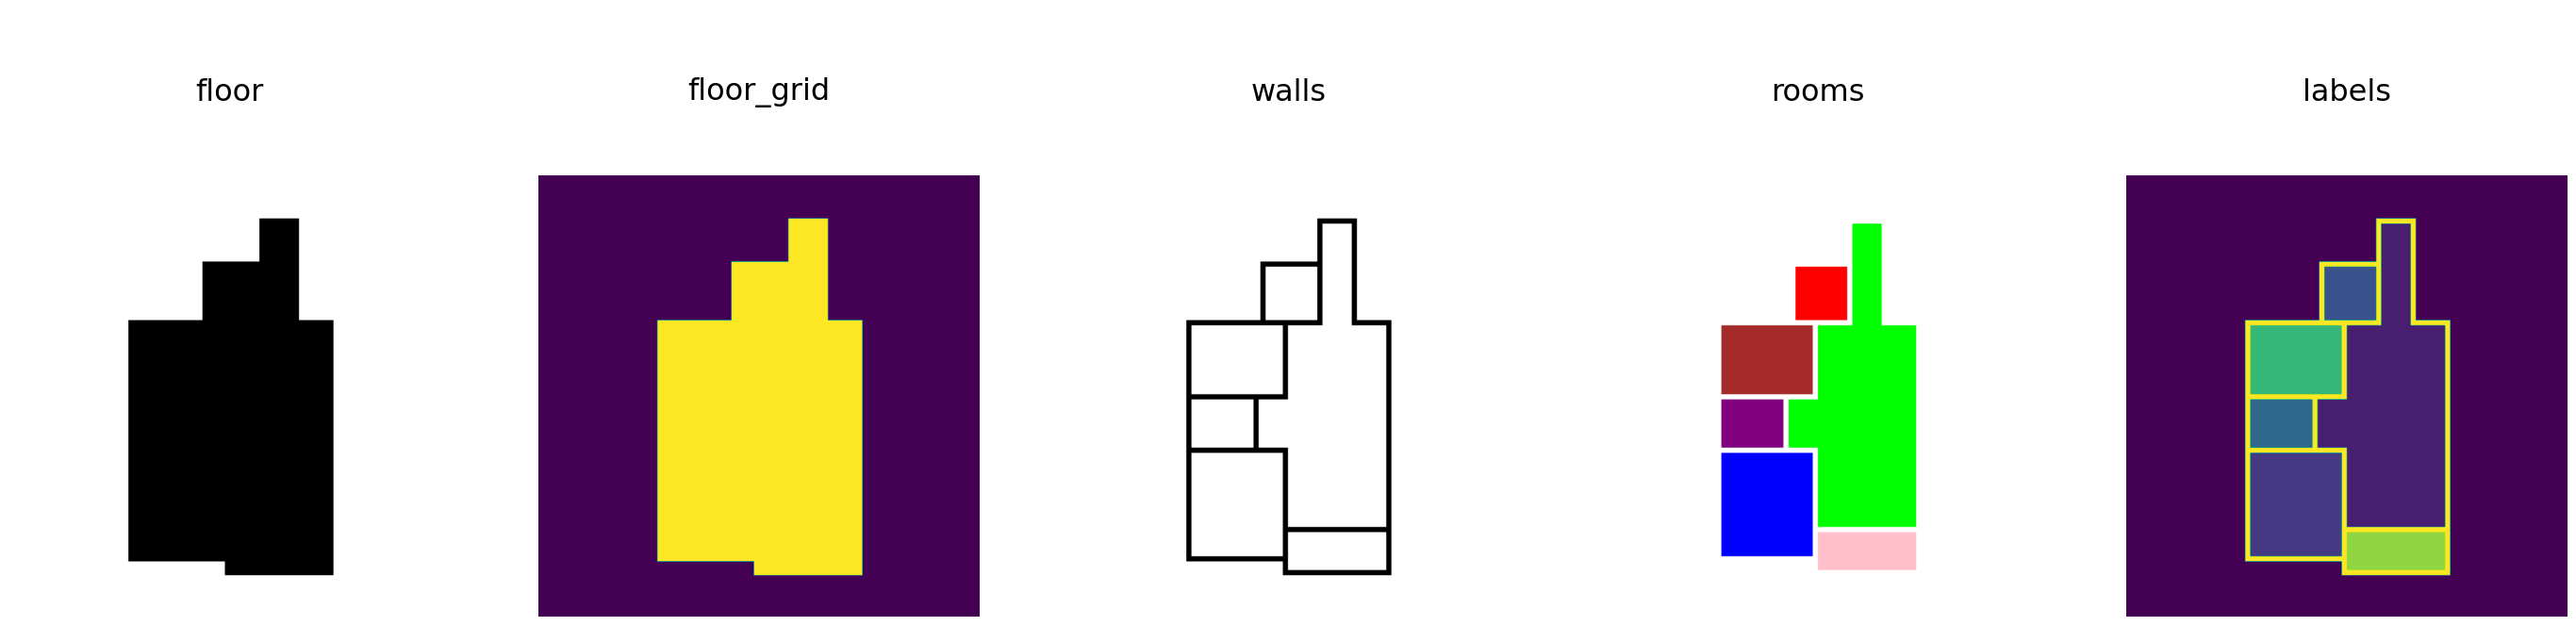

In [29]:
image_names = os.listdir(Configuration.DATA_PATH)

dataset = []

for i, image_name in enumerate(image_names[:1]):
    if i % 5 == 0:
        clear_output(wait=True)
    
    image_path = os.path.join(Configuration.DATA_PATH, image_name)
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 5, figsize=(7 * 5, 7))
        
    ax_1, ax_2, ax_3, ax_4, ax_5 = axes.flatten()
    
    exterior_walls = np.zeros_like(original_image) + Colors.WHITE.value[0]
    exterior_walls_mask = (
        (original_image[:, :, 0] == Labels.EXTERIOR_WALL_1.value)
        | (original_image[:, :, 0] == Labels.MAIN_ENTRANCE.value)
        | (original_image[:, :, 1] == Labels.EXTERIOR_WALL_2.value)
    )
    
    exterior_walls[exterior_walls_mask] = Colors.BLACK.value
    
    floor = np.zeros_like(original_image) + Colors.WHITE.value[0]
    floor[exterior_walls_mask] = Colors.BLACK.value
    _, floor, _, _ = cv2.floodFill(floor, mask=None, seedPoint=(0, 0), newVal=(0, 0, 0))
    floor = abs(Colors.WHITE.value[0] - floor)
    floor[exterior_walls_mask] = Colors.BLACK.value
    
    floor_grid = np.zeros((floor.shape[0], floor.shape[1], 1))
    floor_grid[floor[:, :, 0] == 0] = 1
    
    interior_walls = np.zeros_like(original_image) + Colors.WHITE.value[0]
    interior_walls_mask = (
        (original_image[:, :, 1] == Labels.INTERIOR_WALL.value)
        | (original_image[:, :, 1] == Labels.INTERIOR_DOOR.value)
        | (original_image[:, :, 1] == Labels.WALL_IN.value)
    )
    interior_walls[interior_walls_mask] = Colors.BLACK.value
    
    walls = np.zeros_like(original_image) + Colors.WHITE.value[0]
    walls[exterior_walls_mask] = Colors.BLACK.value
    walls[interior_walls_mask] = Colors.BLACK.value
    
    walls_with_doors = np.zeros_like(original_image) + Colors.WHITE.value[0]
    doors_mask = (
        (original_image[:, :, 0] == Labels.MAIN_ENTRANCE.value)
        | (original_image[:, :, 1] == Labels.FRONT_DOOR.value)
        | (original_image[:, :, 1] == Labels.ENTRANCE.value)
        | (original_image[:, :, 1] == Labels.INTERIOR_DOOR.value)
    )
    
    walls_with_doors[interior_walls_mask] = Colors.BLACK.value
    walls_with_doors[exterior_walls_mask] = Colors.BLACK.value
    walls_with_doors[doors_mask] = Colors.CYAN.value
    
    labels = np.zeros(shape=(original_image.shape[0], original_image.shape[1], 1))
    labels[exterior_walls_mask] = LabelsNew.WALL.value
    labels[interior_walls_mask] = LabelsNew.WALL.value
    
    rooms = np.zeros_like(original_image) + Colors.WHITE.value[0]
    room_types = np.unique(original_image[:, :, 1])
    for room_type in room_types:
        
        room_color = Colors.COLOR_MAP.value.get(room_type)
        if room_color is not None:
            room_mask = original_image[:, :, 1] == room_type
            rooms[room_mask] = room_color
            labels[room_mask] = LabelsNew.CLASS_MAP.value[room_type]
            
    # rooms[exterior_walls_mask] = Colors.BLACK.value
    # rooms[interior_walls_mask] = Colors.BLACK.value
    # rooms[doors_mask] = Colors.CYAN.value
    
    permuted_floor = torch.FloatTensor(floor).permute(2, 0, 1)
    permuted_floor_grid = torch.FloatTensor(floor_grid).permute(2, 0, 1)
    permuted_exterior_walls = torch.FloatTensor(exterior_walls).permute(2, 0, 1)
    permuted_walls = torch.FloatTensor(walls).permute(2, 0, 1)
    permuted_rooms = torch.FloatTensor(rooms).permute(2, 0, 1)
    permuted_labels = torch.FloatTensor(labels).permute(2, 0, 1)
    
    dataset.append(
        [
            permuted_floor, 
            permuted_floor_grid,
            permuted_exterior_walls, 
            permuted_walls, 
            permuted_rooms, 
            permuted_labels
        ]
    )
    
    components = [floor, floor_grid, walls, rooms, labels]
    titles = ["floor", "floor_grid", "walls", "rooms", "labels"]
    
    for ax, component, title in zip(axes.flatten(), components, titles):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("\n\n" + title + "\n\n", fontsize=23)
        ax.axis("off")
        ax.imshow(component)
        

In [30]:
from torch.utils.data import Dataset, DataLoader

BATCH_SIZE = 1

class PlanDataset(Dataset):
    def __init__(self, plan_dataset):
        self.plan_dataset = plan_dataset
    
    def __len__(self):
        return len(self.plan_dataset)
    
    def __getitem__(self, index):
        # floor, exterior_walls, walls, rooms, labels
        _, floor_grid, _, _, _, labels = self.plan_dataset[index]
        return floor_grid.to("cuda"), labels.to("cuda")
    
plan_dataset = PlanDataset(dataset)
plan_dataloader = DataLoader(
    dataset=plan_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [35]:
from IPython.display import clear_output
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as functional

class UNet(nn.Module):
    def __init__(self, n_classes):
        
        super(UNet, self).__init__()
        self.encoding_1 = self.encode(1, 32)
        self.encoding_2 = self.encode(32, 64)
        self.encoding_3 = self.encode(64, 128)
        self.encoding_4 = self.encode(128, 256)
        self.encoding_5 = self.encode(256, 512)
        self.encoding_6 = self.encode(512, 1024)
        
        self.upconv_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.upconv_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv_5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        
        self.conv_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv_3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv_4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv_5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv_6 = nn.Conv2d(32, n_classes, kernel_size=1)
        
        self.to("cuda")
        
    def encode(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def decode(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, floor):
        encoded_1 = self.encoding_1(floor)
        encoded_2 = functional.max_pool2d(self.encoding_2(encoded_1), kernel_size=2)
        encoded_3 = functional.max_pool2d(self.encoding_3(encoded_2), kernel_size=2)
        encoded_4 = functional.max_pool2d(self.encoding_4(encoded_3), kernel_size=2)
        encoded_5 = functional.max_pool2d(self.encoding_5(encoded_4), kernel_size=2)
        encoded_6 = functional.max_pool2d(self.encoding_6(encoded_5), kernel_size=2)
        
        decoded_1 = self.conv_1(torch.cat([self.upconv_1(encoded_6), encoded_5], dim=1))
        decoded_2 = self.conv_2(torch.cat([self.upconv_2(decoded_1), encoded_4], dim=1))
        decoded_3 = self.conv_3(torch.cat([self.upconv_3(decoded_2), encoded_3], dim=1))
        decoded_4 = self.conv_4(torch.cat([self.upconv_4(decoded_3), encoded_2], dim=1))
        decoded_5 = self.conv_5(torch.cat([self.upconv_5(decoded_4), encoded_1], dim=1))
        decoded_6 = self.conv_6(decoded_5)
        
        return decoded_6

model = UNet(LabelsNew.NUM_CLASSES.value)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 1000 + 1):
    for floor, labels in plan_dataloader:
        optimizer.zero_grad()
        
        # interior = floor == 1
        # noise = torch.normal(0, 1, size=floor.shape).to("cuda")
        # floor[interior] = noise[interior]
        
        predictions = model(floor)
        loss = loss_function(predictions, labels.squeeze(1).long())
        loss.backward()
        optimizer.step()
        
        # Visualization of predictions
        predictions_np = predictions.detach().cpu().numpy()
        predictions_np = np.argmax(predictions_np, axis=1)  # Get the class with the highest score
        
        fig, ax = plt.subplots(1, 1, figsize=(7, 7))
        ax.imshow(predictions_np[0], cmap='gray')  # Assuming single-channel output
        ax.axis('off')
        
        print(epoch, loss)
        plt.show()
        clear_output(wait=True)

101 tensor(0.0016, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


KeyboardInterrupt: 

In [13]:
from IPython.display import clear_output
from torch import nn


class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(256 * 256 * 3, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
        )

        self.main = nn.Sequential(
            nn.ConvTranspose2d(256, 1024, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(3),
        )
        
        self.to("cuda")

    def forward(self, z, floor):
        fc = self.linear(floor.reshape(floor.shape[0], -1))
        x = torch.cat([z, fc], dim=1)
        x = x.reshape(x.shape[0], 256, 1, 1)
        x = self.main(x)

        return nn.Tanh()(x)
    
    
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=0, bias=False),
            nn.AdaptiveAvgPool2d(1),
            nn.Sigmoid(),
        )
        
        self.to("cuda")
        
    def forward(self, x):
        return self.main(x).flatten()

generator = Generator()
discriminator = Discriminator()
loss_fn = nn.BCELoss()

d_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


for _ in range(200):
    print(_)
    for data in plan_dataloader:
        floor, rooms = data
        
        d_optimizer.zero_grad()
        
        z = torch.randn((floor.shape[0], 128), requires_grad=True).to("cuda")
        
        generated_plan = generator(z, floor)
        
        real_d = discriminator(rooms)
        fake_d = discriminator(generated_plan)
        
        discriminator_loss_real = loss_fn(real_d, torch.ones_like(real_d))
        discriminator_loss_real.backward()
        
        discriminator_loss_fake = loss_fn(fake_d, torch.zeros_like(fake_d))
        discriminator_loss_fake.backward()
        
        discriminator_loss = discriminator_loss_real + discriminator_loss_fake
        d_optimizer.step()
        
        g_optimizer.zero_grad()
        
        z = torch.randn((floor.shape[0], 128), requires_grad=True).to("cuda")
        generated_plan = generator(z, floor)
        
        fake_d = discriminator(generated_plan)
        generator_loss = loss_fn(fake_d, torch.ones_like(fake_d))
        
        generator_loss.backward()
        g_optimizer.step()
        
        # Visualization of generated_plan
        generated_plan_np = generated_plan.detach().cpu().numpy()
        generated_plan_np = (generated_plan_np + 1) / 2  # Rescale from [-1, 1] to [0, 1]
        
        print(generator_loss.mean())
        print(discriminator_loss.mean())
        
        fig, ax = plt.subplots(1, 1, figsize=(7, 7))
        ax.imshow(np.transpose(generated_plan_np[0], (1, 2, 0)))
        ax.axis('off')
        
        plt.show()
        clear_output(wait=True)
        

72
tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0677, device='cuda:0', grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [13]:
np.transpose(generated_plan_np[0], (1, 2, 0)).shape

(256, 256, 3)